# Summary
In this notebook mass differences are extracted from the AllPositive dataset and expressed per spectrum. This dataset is constructed here: https://github.com/iomega/spec2vec_gnps_data_analysis/tree/master/notebooks just like the pickled ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups file, and the pickled gnps_positive_ionmode_cleaned_by_matchms_and_lookups file is created here: https://github.com/louwenjjr/improve_library_matching .

Steps in this notebook:
- Reading spectra
- Processing spectra
- Extracting mass differences (new) and fragments + neutral losses ('normal')

In [88]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from math import ceil

data_path = "/mnt/scratch/louwe015/Mass_differences/data/"

## Determine AllPositive version; default is version 2

In [89]:
all_pos_version1 = False
if all_pos_version1:
    all_pos = "gnps_positive_ionmode_cleaned_by_matchms_and_lookups"
else:
    all_pos = "ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups"

print(all_pos)

ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups


## Reading spectra

In [90]:
all_positive_file = os.path.join(data_path, all_pos + ".pickle")
if os.path.exists(all_positive_file):
    with open(all_positive_file, 'rb') as inf:
        spectrums = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")

In [91]:
print("number of spectra:", len(spectrums))

number of spectra: 144691


## Processing spectra
Similar to Xing et al. (2020) https://pubs-acs-org.ezproxy.library.wur.nl/doi/full/10.1021/acs.analchem.0c02521
In Xing they also do square root transformation on the normalised intensities. We don't do that here (yet).

Steps:
- remove precursor_mz peak (to prevent neutral losses ending up in MDs)
- normalise peaks (maximum intensity to 1)
- remove peaks outside [0, 1000] m/z window
- select top 30 intensity peaks (from Xing et al. (2020))
- remove peaks with intensities < 0.001 of maximum intensity

In [92]:
from matchms.Spikes import Spikes
from matchms.typing import SpectrumType


def remove_precursor_mz_peak(spectrum_in: SpectrumType) -> SpectrumType:
    """Remove the peak for precursor_mz in the spectrum (if it exists)
    
    Parameters
    ----------
    spectrum_in:
        Input spectrum.
    """
    if spectrum_in is None:
            return None

    spectrum = spectrum_in.clone()

    prec_mz = spectrum.get("precursor_mz")
    before_len = len(spectrum.peaks)
    if prec_mz:  # precursor_mz exists
        mzs, intensities = spectrum.peaks.clone()
        prec_mz_i = [i for i, mz in enumerate(mzs) if mz == prec_mz]
        if prec_mz_i:  # precursor_mz peak exists -> remove it
            new_mzs = np.delete(mzs, prec_mz_i)
            new_intensities = np.delete(intensities, prec_mz_i)
            new_spikes = Spikes(mz=new_mzs, intensities=new_intensities)
            spectrum.peaks = new_spikes
            after_len = len(spectrum.peaks)
            assert after_len == before_len-1, "Expected only one peak to have been removed"

    return spectrum

In [93]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_normal(s, min_peaks=10):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=min_peaks)
    s = reduce_to_number_of_peaks(s, n_required=min_peaks, ratio_desired=0.5)
    if s is None:
        return None
    #remove low peaks unless less than 10 peaks are left
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
    #add losses to normally processed spectra
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

def post_process_md(s, min_peaks=10, max_peaks=30):
    #remove precurzor_mz from spectra for top30, so neutral losses don't end up in MDs
    s = remove_precursor_mz_peak(s)
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=min_peaks)
    s = reduce_to_number_of_peaks(s, n_required=min_peaks, ratio_desired=0.5)
    if s is None:
        return None
    #remove low peaks unless less than 10 peaks are left
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
    
    #reduce to top30 peaks
    s = reduce_to_number_of_peaks(s, n_required=min_peaks, n_max=max_peaks)
    return s

spectrums_top30 = []
spectrums_processed = []
minimum_peaks = 10
maximum_peaks = 30
for spec in spectrums:
    s_top30 = post_process_md(spec, min_peaks=minimum_peaks, max_peaks=maximum_peaks)
    s_normal = post_process_normal(spec, min_peaks=minimum_peaks)
    if s_top30 is not None and s_normal is not None:
        spectrums_top30.append(s_top30)
        spectrums_processed.append(s_normal)

print("{} remaining top30 spectra.".format(len(spectrums_top30)))
print("as a check: {} remaining spectra in normally processed data.".format(len(spectrums_processed)))

115344 remaining top30 spectra.
as a check: 115344 remaining spectra in normally processed data.


In [105]:
x=5
print(spectrums_top30[x].metadata.get("spectrumid") == spectrums_processed[x].metadata.get("spectrumid"))
print(spectrums_top30[x].metadata.get("spectrumid"), spectrums_processed[x].metadata.get("spectrumid"))

True
CCMSLIB00000001552 CCMSLIB00000001552


In [106]:
# save top30 and normally processed file
top30_file = os.path.join(data_path, all_pos + "_top30_peaks.pickle")
with open(top30_file, 'wb') as outf:
    pickle.dump(spectrums_top30, outf)
processed_file = os.path.join(data_path, all_pos + "_processed.pickle")
with open(processed_file, 'wb') as outf:
    pickle.dump(spectrums_processed, outf)

In [107]:
# load top30 file
top30_file = os.path.join(data_path, all_pos + "_top30_peaks.pickle")
if os.path.exists(top30_file):
    with open(top30_file, 'rb') as inf:
        spectrums_top30 = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")

In [108]:
# load processed file
processed_file = os.path.join(data_path, all_pos + "_processed.pickle")
if os.path.exists(processed_file):
    with open(processed_file, 'rb') as inf:
        spectrums_processed = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")

In [109]:
spec0 = spectrums_top30[0]
[i for i in spec0.peaks]

[array([456.107544, 469.872314, 515.922852, 538.003174, 539.217773,
        554.117432, 556.030396, 582.110107, 599.352783, 600.382812,
        696.332397, 724.081909, 830.409302, 839.455811, 847.433594,
        851.380859, 852.370605, 866.295654, 868.372192, 909.424438,
        919.39624 , 932.351929, 936.552002, 939.61792 , 949.370239,
        953.396606, 954.491577, 963.686768, 964.524658, 965.192139]),
 array([0.13785328, 0.1145734 , 0.10302372, 0.28900242, 0.35616456,
        0.09970269, 0.28046377, 0.13351462, 1.        , 0.14946182,
        0.15854461, 0.11577153, 0.13417909, 0.09418422, 0.2569733 ,
        0.32199162, 0.36216307, 0.14520426, 0.10205448, 0.31933114,
        0.11226477, 0.17874806, 0.13489457, 0.10109441, 0.1117298 ,
        0.71323034, 0.16211023, 0.34214536, 0.41616014, 0.16272238])]

## Create SpectrumDocuments from normally processed Spectrums

In [110]:
from spec2vec import SpectrumDocument
documents_spectrums_processed = [SpectrumDocument(s, n_decimals=2) for s in spectrums_processed]

In [111]:
print(len(documents_spectrums_processed))

115344


In [112]:
# save SpectrumDocuments from normally processed spectra
documents_file = os.path.join(data_path, all_pos + "_processed_documents.pickle")
with open(documents_file, 'wb') as outf:
    pickle.dump(documents_spectrums_processed, outf)

## Get mass differences
Mass differences are sorted on size, a cutoff of 36 is used and a maximum of 100 mass differences are extracted.

In [113]:
from matchms.Spikes import Spikes
from matchms.typing import SpectrumType

def get_mass_differences(spectrum_in: SpectrumType, cutoff: int = 36, n_max: int = 100) -> Spikes:
    """Returns Spikes with top 100 mass differences and intensities
    
    Parameters:
    spectrum_in:
        Spectrum in matchms.Spectrum format
    cutoff:
        Mass cutoff for mass difference (like Xing et al.)
    n_max:
        Maximum amount of mass differences to select, ranked on intensity (like Xing et al.)
    """
    if spectrum_in is None:
        return None

    spectrum = spectrum_in.clone()
    peaks_mz, peaks_intensities = spectrum.peaks
    mass_diff_mz = []
    mass_diff_intensities = []
    for i, (mz_i, int_i) in enumerate(zip(peaks_mz[:-1], peaks_intensities[:-1])):
        for mz_j, int_j in zip(peaks_mz[i+1:], peaks_intensities[i+1:]):
            mz_diff = mz_j-mz_i
            if mz_diff > cutoff:
                mass_diff_mz.append(mz_diff)
                mass_diff_intensities.append(np.mean([int_i, int_j]))
    mass_diff_mz = np.array(mass_diff_mz)
    mass_diff_intensities = np.array(mass_diff_intensities)
    idx = mass_diff_intensities.argsort()[-n_max:]
    idx_sort_by_mz = mass_diff_mz[idx].argsort()
    mass_diff_peaks = Spikes(mz=mass_diff_mz[idx][idx_sort_by_mz],
                             intensities=mass_diff_intensities[idx][idx_sort_by_mz])
    return mass_diff_peaks


In [114]:
get_mass_differences(spectrums_top30[0])[:]

[array([ 43.322387,  43.972168,  45.128418,  45.235351,  54.26233 ,
         55.10022 ,  57.053833,  58.043579,  60.13501 ,  61.165039,
         61.349609,  61.990844,  79.981324,  80.97107 ,  83.429931,
         85.024414,  87.100952,  96.152466,  96.979614,  98.229004,
        101.026001, 102.015747, 102.120972, 105.963012, 111.316163,
        112.154053, 112.305909, 112.821534, 113.143799, 113.940795,
        116.253174, 117.091064, 122.987304, 124.729126, 125.068847,
        129.480469, 134.115356, 143.245239, 156.038208, 157.114624,
        229.314697, 231.056519, 240.103028, 240.442749, 248.080811,
        251.987793, 252.028076, 253.017822, 257.064209, 266.942871,
        268.192261, 269.019409, 291.403198, 295.350463, 296.340209,
        308.215821, 309.43042 , 310.071655, 312.163086, 313.152832,
        313.377685, 314.367431, 320.043457, 327.077881, 332.999146,
        337.199219, 340.265137, 350.017456, 353.013794, 353.394042,
        354.043823, 355.138794, 364.141846, 364.

In [115]:
mass_differences = []
for spec in spectrums_top30:
    mass_differences.append(get_mass_differences(spec))  # list of Spikes

In [116]:
# save mass differences file
mass_differences_file = os.path.join(data_path, all_pos + "_top30_mass_differences.pickle")
with open(mass_differences_file, 'wb') as outf:
    pickle.dump(mass_differences, outf)

In [117]:
len(mass_differences)

115344

In [118]:
# load mass differences file
mass_differences_file = os.path.join(data_path, all_pos + "_top30_mass_differences.pickle")
if os.path.exists(mass_differences_file):
    with open(mass_differences_file, 'rb') as inf:
        mass_differences = pickle.load(inf) # list of Spikes for each spectrum
    print(len(mass_differences))  # should be library length
else:
    print("error")

115344


## Bin mass differences
Bin mass differences on 2 decimals to start.

In [119]:
mass_differences_2dec = []
n_decimals = 2
for mz, intensity in mass_differences:
    mz_round_str = [f"{mz_i:.{n_decimals}f}" for mz_i in mz]
    mass_differences_2dec.append(mz_round_str)

In [120]:
total_mass_differences_2dec = [md_mz for mds in mass_differences_2dec for md_mz in mds]
unique_mass_differences_2dec = set(total_mass_differences_2dec)

print(f"{len(total_mass_differences_2dec)} total mass differences 2 dec. On average \
{len(total_mass_differences_2dec)/len(mass_differences_2dec)} per spectrum")
print(f"{len(unique_mass_differences_2dec)} unique mass differences 2 dec")

10528896 total mass differences 2 dec. On average 91.28256346233874 per spectrum
77404 unique mass differences 2 dec


In [121]:
# find out about same mds in one spectrum, read '1: 7079085' as there are 7079085 times a mass difference instance
# occurs in a spectrum on their own, 2: 609235 as there are 609235 times there are two the same mds in a spectrum
# which represents 609235*2 md instances, etc.
from collections import Counter
counts = Counter()
for mds in mass_differences_2dec:
    counts.update(Counter(mds).values())
counts

Counter({1: 8223055,
         2: 761751,
         3: 140305,
         4: 44170,
         7: 3421,
         5: 16502,
         6: 7209,
         10: 451,
         12: 90,
         8: 1842,
         31: 3,
         34: 1,
         13: 34,
         9: 1013,
         14: 30,
         22: 5,
         17: 17,
         15: 20,
         20: 11,
         66: 1,
         28: 3,
         16: 22,
         18: 12,
         11: 190,
         25: 1,
         23: 5,
         24: 5,
         32: 2,
         27: 2,
         19: 10,
         21: 5,
         36: 1,
         30: 2,
         43: 1,
         33: 1,
         29: 1})

## Bin on 2 decimals and represent mass difference spectrum 'document'
Each spectrum is for now a list of tuples: [(md_mz, [sorted_intensities], counts)]

Mass differences are binned here in 2decimals

In [122]:
from collections import defaultdict
md_documents = []
n_decimals = 2
for mz, intensities in mass_differences:
    mz_round_strs = [f"{mz_i:.{n_decimals}f}" for mz_i in mz]
    summary = defaultdict(list)
    for mz_round_str, intensity in zip(mz_round_strs, intensities):
        summary[mz_round_str].append(intensity)
    info_tup = [(key, sorted(vals, reverse=True), len(vals)) for key, vals in summary.items()]
    info_tup.sort(key=lambda x: x[2], reverse=True)
    md_documents.append(info_tup)

In [123]:
md_documents[-1]

[('54.04', [0.1807188058927486, 0.16162577383586318], 2),
 ('55.07', [0.17487617579975762, 0.1670455844531615], 2),
 ('56.06', [0.19203706088082417, 0.17138531409588814], 2),
 ('82.08', [0.6372654923856096, 0.1850372112858543], 2),
 ('83.09', [0.5319468994589739, 0.15687420657181958], 2),
 ('84.10', [0.6196561735547551, 0.26253623403346044], 2),
 ('85.10', [0.2730899199166406, 0.1572176411068247], 2),
 ('108.09', [0.5384646679205761, 0.15502824601006174], 2),
 ('110.11', [0.5473635783596839, 0.16373540956842697], 2),
 ('111.11', [0.20079732472156941, 0.17087415571820608], 2),
 ('299.20', [0.5206877189168174, 0.1689157162889144], 2),
 ('299.29', [0.7905134196426691, 0.3092052685356723], 2),
 ('381.37', [0.42777891202827867, 0.18737498709775555], 2),
 ('53.04', [0.527285059530863], 1),
 ('54.05', [0.5667663192329734], 1),
 ('54.06', [0.15929283371000438], 1),
 ('54.07', [0.5214424294378721], 1),
 ('55.04', [0.1582178693030037], 1),
 ('55.05', [0.22020006559485888], 1),
 ('58.08', [0.1537

In [124]:
# save md documents
md_documents_file = os.path.join(data_path, all_pos + "_mass_difference_documents.pickle")
with open(md_documents_file, 'wb') as outf:
    pickle.dump(md_documents, outf)

In [125]:
# load md documents
md_documents_file = os.path.join(data_path, all_pos + "_mass_difference_documents.pickle")
if os.path.exists(md_documents_file):
    with open(md_documents_file, 'rb') as inf:
        md_documents = pickle.load(inf)  # list of list of tuples 'documents'
    print(len(md_documents))
else:
    print("error")

115344


## Some info per MD

In [126]:
from collections import defaultdict

# dict of {md: [count for how many times it occurs in spectrumA, etc.]}
per_md_counts = defaultdict(list)
for doc in md_documents:
    for tup in doc:
        per_md_counts[tup[0]].append(tup[2])
print(len(per_md_counts), "Mass differences present in dataset")

77404 Mass differences present in dataset


[3, 16, 7, 3, 1, 4, 9, 8, 2, 3] 66


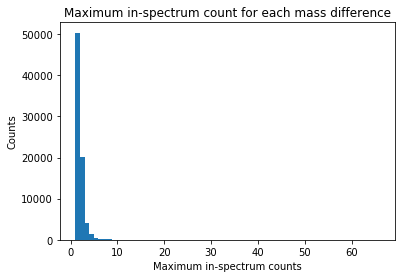

In [127]:
# summarise the highest in-spectrum-count for each MD
highest_count_per_md = [max(vals) for vals in per_md_counts.values()]
print(highest_count_per_md[:10], max(highest_count_per_md))
plt.hist(highest_count_per_md, bins = max(highest_count_per_md))
plt.title("Maximum in-spectrum count for each mass difference")
plt.xlabel("Maximum in-spectrum counts")
plt.ylabel("Counts")
plt.show()

In [128]:
# in how many spectra does a md occur (at least once)
md_spectrum_occurrences = {key:len(vals) for key, vals in per_md_counts.items()}
occurrences = md_spectrum_occurrences.values()
h_num = 25
highest_occ = sorted(occurrences)[-h_num:]
highest_mds = [(key,val) for key,val in md_spectrum_occurrences.items() if val in highest_occ]
print(f"highest {h_num} occurrences:\n" +\
      '\n'.join([f"{key}\t{val}"for key, val in sorted(highest_mds, key=lambda x: x[1], reverse=True)]))

highest 25 occurrences:
42.01	35070
40.03	30305
38.02	28643
42.05	23607
46.01	23318
52.03	22822
44.03	21919
60.02	20448
54.05	20019
43.99	19162
50.02	18884
55.99	18025
54.01	17913
39.99	16946
56.03	16830
56.06	16478
36.02	15512
64.03	14953
80.06	14860
66.05	14833
43.02	14529
59.01	14469
48.00	14079
80.03	13694
41.00	13552


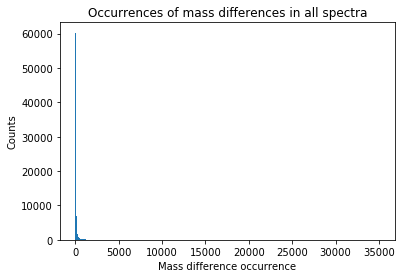

3137 mass differences occur in over 500 spectra


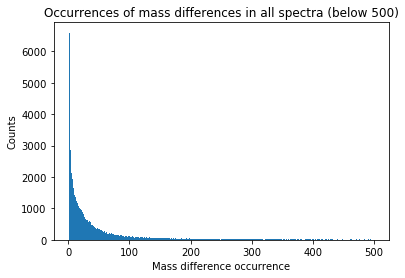

In [129]:
from collections import Counter
# summarise all occurrences
occurrence_counts = Counter(occurrences)
plt.subplots(0)
plt.hist(occurrences, bins = 500)
plt.title("Occurrences of mass differences in all spectra")
plt.xlabel("Mass difference occurrence")
plt.ylabel("Counts")
plt.show()

plt.subplots(1)
cut = 500
occurrences_below_cut = [occ for occ in occurrences if occ < cut]
print(f"{len(occurrences) - len(occurrences_below_cut)} mass differences occur in over {cut} spectra")
plt.hist(occurrences_below_cut, bins = cut)
plt.title(f"Occurrences of mass differences in all spectra (below {cut})")
plt.xlabel("Mass difference occurrence")
plt.ylabel("Counts")
plt.show()

In [130]:
occurrence_counts.most_common()[:50]

[(1, 6592),
 (2, 4172),
 (3, 2865),
 (4, 2427),
 (5, 2120),
 (6, 1938),
 (7, 1792),
 (8, 1633),
 (9, 1499),
 (10, 1441),
 (11, 1369),
 (12, 1342),
 (13, 1251),
 (14, 1243),
 (15, 1176),
 (17, 1131),
 (16, 1082),
 (18, 1004),
 (19, 1003),
 (20, 965),
 (21, 953),
 (22, 905),
 (23, 878),
 (24, 829),
 (25, 773),
 (26, 738),
 (27, 725),
 (30, 672),
 (28, 669),
 (31, 632),
 (29, 628),
 (34, 594),
 (32, 592),
 (33, 558),
 (36, 557),
 (35, 548),
 (37, 504),
 (38, 476),
 (39, 476),
 (40, 466),
 (42, 434),
 (41, 430),
 (43, 412),
 (45, 396),
 (44, 386),
 (47, 380),
 (50, 350),
 (46, 348),
 (48, 348),
 (49, 347)]

In [131]:
occ_min = 5
occ_max = ceil(0.05*len(md_documents))
num_md_occ_cutoff = sum(occurrence_counts.get(key, 0) for key in range(occ_min, occ_max))
print(f"Number of mass differences that occur in between {occ_min} and {occ_max} spectra: {num_md_occ_cutoff}")

Number of mass differences that occur in between 5 and 5768 spectra: 61190


## Filter out mass differences that occur outside of cutoff
keep MDs with occurrence lower than 5 spectra. Don't use max occurrence cutoff for now, for example cutoff of 5% of spectra only removes 33 MDs, and we can relate most occurring MDs to masses from Xing et al: 42.01 is acetylation for example.

In [132]:
occ_min = 5
max_occ_fraction = 1
occ_max = ceil(max_occ_fraction*len(md_documents))
print(f"Minimum occurrence cutoff: {occ_min}. Maximum occurrence cutoff ({max_occ_fraction}*len(spectra)): {occ_max}.")
black_list = set(md for md, occ in md_spectrum_occurrences.items() if occ < occ_min or occ >= occ_max)
print(f"{len(black_list)} MDs to filter out, leaving {len(per_md_counts)-len(black_list)} MDs.")

Minimum occurrence cutoff: 5. Maximum occurrence cutoff (1*len(spectra)): 115344.
16056 MDs to filter out, leaving 61348 MDs.


In [133]:
md_documents_filtered = [[tup for tup in doc if tup[0] not in black_list] for doc in md_documents]

In [134]:
#exemples of filtered and non filtered mass differences
x=12
print(len(md_documents_filtered[x]), len(md_documents[x]))


x=13
print(len(md_documents_filtered[x]), len(md_documents[x]))

100 100
86 91


In [135]:
# save md documents filtered
md_documents_filtered_file = os.path.join(data_path, all_pos + "_mass_difference_documents_filtered.pickle")
with open(md_documents_filtered_file, 'wb') as outf:
    pickle.dump(md_documents_filtered, outf)

In [136]:
# load md documents
md_documents_filtered_file = os.path.join(data_path, all_pos + "_mass_difference_documents_filtered.pickle")
if os.path.exists(md_documents_filtered_file):
    with open(md_documents_filtered_file, 'rb') as inf:
        md_documents_filtered = pickle.load(inf)  # list of list of tuples 'documents'
    print(len(md_documents_filtered))
else:
    print("error")

115344


## Plot same statistics again for filtered data

In [137]:
from collections import defaultdict

# dict of {md: [count for how many times it occurs in spectrumA, etc.]} for fitered data
per_md_counts_filtered = defaultdict(list)
for doc in md_documents_filtered:
    for tup in doc:
        per_md_counts_filtered[tup[0]].append(tup[2])
print("Number of mass differences left:", len(per_md_counts_filtered))

Number of mass differences left: 61348


[3, 16, 7, 3, 1, 4, 9, 8, 2, 3] 66


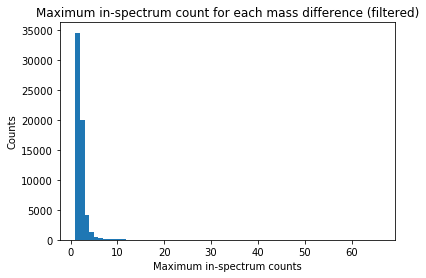

In [138]:
# summarise the highest in-spectrum-count for each MD filtered
highest_count_per_md_filtered = [max(vals) for vals in per_md_counts_filtered.values()]
print(highest_count_per_md_filtered[:10], max(highest_count_per_md_filtered))
plt.hist(highest_count_per_md_filtered, bins = max(highest_count_per_md_filtered))
plt.title("Maximum in-spectrum count for each mass difference (filtered)")
plt.xlabel("Maximum in-spectrum counts")
plt.ylabel("Counts")
plt.show()

In [139]:
# in how many spectra does a md occur (at least once) (filtered)
md_spectrum_occurrences_filtered = {key:len(vals) for key, vals in per_md_counts_filtered.items()}
occurrences_filtered = md_spectrum_occurrences_filtered.values()
h_num = 25
highest_occ_filtered = sorted(occurrences_filtered)[-h_num:]
highest_mds_filtered = [(key,val) for key,val in md_spectrum_occurrences_filtered.items() if val in highest_occ_filtered]
print(f"highest {h_num} occurrences:\n" +\
      '\n'.join([f"{key}\t{val}"for key, val in sorted(highest_mds_filtered, key=lambda x: x[1], reverse=True)]))

highest 25 occurrences:
42.01	35070
40.03	30305
38.02	28643
42.05	23607
46.01	23318
52.03	22822
44.03	21919
60.02	20448
54.05	20019
43.99	19162
50.02	18884
55.99	18025
54.01	17913
39.99	16946
56.03	16830
56.06	16478
36.02	15512
64.03	14953
80.06	14860
66.05	14833
43.02	14529
59.01	14469
48.00	14079
80.03	13694
41.00	13552


In [140]:
md_spectrum_occurrences_filtered.get('162.05')  # hexose

4072

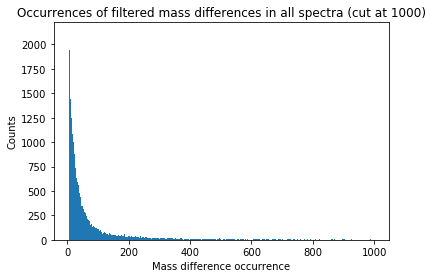

In [141]:
from collections import Counter
# summarise all occurrences filtered
occurrence_counts_filtered = Counter(occurrences_filtered)

#only display occurrences below 1000 otherwise the plot becomes unusable
cut = 1000
occurrences_filtered_cut = [occ for occ in occurrences_filtered if occ < cut]
plt.subplots(0)
plt.hist(occurrences_filtered_cut, bins = max(occurrences_filtered_cut)-5) # bin on integers
plt.title("Occurrences of filtered mass differences in all spectra (cut at 1000)")
plt.xlabel("Mass difference occurrence")
plt.ylabel("Counts")
plt.show()

In [142]:
occurrence_counts_filtered.most_common()[:10], occurrence_counts_filtered.most_common()[-10:]

([(5, 2120),
  (6, 1938),
  (7, 1792),
  (8, 1633),
  (9, 1499),
  (10, 1441),
  (11, 1369),
  (12, 1342),
  (13, 1251),
  (14, 1243)],
 [(1979, 1),
  (1843, 1),
  (1087, 1),
  (1612, 1),
  (2795, 1),
  (1672, 1),
  (1466, 1),
  (1319, 1),
  (875, 1),
  (1177, 1)])

## Plot m/z of the filtered MDs

In [143]:
all_filtered_mds_mz = [float(key) for key in per_md_counts_filtered.keys()]

In [144]:
filtered_mds_mz, filtered_mds_occurences = zip(*[(float(key), val) for key, val in md_spectrum_occurrences_filtered.items()])

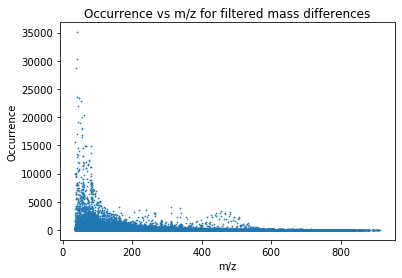

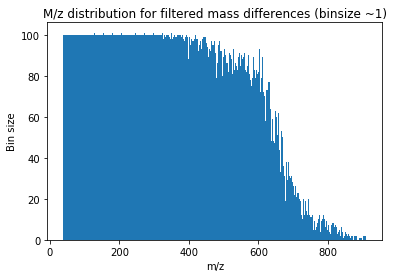

In [145]:
# mz versus occurrence
plt.scatter(filtered_mds_mz, filtered_mds_occurences, s=0.5)
plt.title("Occurrence vs m/z for filtered mass differences")
plt.ylabel("Occurrence")
plt.xlabel("m/z")
plt.show()

plt.hist(filtered_mds_mz, bins = int(max(filtered_mds_mz)-min(filtered_mds_mz)))  # bin more or less on integers
plt.title("M/z distribution for filtered mass differences (binsize ~1)")
plt.ylabel("Bin size")
plt.xlabel("m/z")
plt.show()

## Finding some examples
Like hexose: 162.05 / .06/ .04

In [146]:
#occurrences
md_spectrum_occurrences_filtered.get('162.05')

4072